In [1]:
import requests
import json
import time
import traceback
import pymysql
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [104]:
# connect to the database
dbikes = pymysql.Connect(
    host = "dbikes.ccike2q3zkya.eu-west-1.rds.amazonaws.com",
    user = "admin",
    passwd = "admin2022",
    database = "dbikes")

In [105]:
# read database and assign each table to dataframe structure
static_station = pd.read_sql_query("SELECT * FROM static_station", dbikes)
dynamic_station = pd.read_sql_query("SELECT * FROM dynamic_station", dbikes)
dynamic_weather = pd.read_sql_query("SELECT * FROM dynamic_weather", dbikes)

# Whole Dataset 

## Data Process : Sample 20% Data for the whole dataset

In [4]:
# sample 20%
static_station_20percent = static_station
dynamic_station_20percent = dynamic_station.sample(frac=0.2)
dynamic_weather_20percent = dynamic_weather.sample(frac=0.2)

In [5]:
# drop the duplicate data
dynamic_station_20percent = dynamic_station_20percent.drop_duplicates()
dynamic_station_20percent = dynamic_station_20percent.dropna()
dynamic_weather_20percent = dynamic_weather_20percent.drop_duplicates()
dynamic_weather_20percent = dynamic_weather_20percent.dropna()
# convert the timestamp to date week and hours
dynamic_station_20percent["last_update"] = pd.to_datetime(dynamic_station_20percent["last_update"], unit = "ms")
dynamic_weather_20percent["last_update"] = pd.to_datetime(dynamic_weather_20percent["dt"], unit = "s")
# add weekday to table as a column
dynamic_station_20percent["weekday"] = dynamic_station_20percent["last_update"].map(lambda x: x.weekday())
dynamic_weather_20percent["weekday"] = dynamic_weather_20percent["last_update"].map(lambda x: x.weekday())
# add hour to table as a column
dynamic_station_20percent["hour"] = pd.to_datetime(dynamic_station_20percent["last_update"], format='%Y-%M-%D %H:%M:%S').dt.hour
dynamic_weather_20percent["hour"] = pd.to_datetime(dynamic_weather_20percent["last_update"], format='%Y-%M-%D %H:%M:%S').dt.hour

In [6]:
# merge two dynamic dataframe according to the nearest date
dynamic_station_20percent = dynamic_station_20percent.sort_values(['last_update'])
dynamic_weather_20percent = dynamic_weather_20percent.sort_values(['last_update'])
dynamic_weather_20percent = dynamic_weather_20percent.drop(columns=["weekday","hour","dt"])
station_weather_20percent = pd.merge_asof(dynamic_station_20percent, dynamic_weather_20percent,
                               on = "last_update",by = "number", 
                                direction="nearest", tolerance = pd.Timedelta("2 hour"))
static_station_20percent = static_station_20percent.drop(columns=["name","lat","lng"])
station_weather_20percent = pd.merge(station_weather_20percent,static_station_20percent)
station_weather_20percent = station_weather_20percent.dropna()
station_weather_20percent = station_weather_20percent.drop_duplicates()

### Correlation Coefficient Table

In [7]:
station_weather_20percent.corr()

,number,available_bike_stands,available_bikes,weekday,hour,lat,lng,temp,pressure,wind_speed,humidity,bike_stands
number,1.000000,0.353479,0.065383,-0.001759,-0.014240,0.181851,-0.219960,-0.006906,0.002091,-0.001837,0.003938,0.553113
available_bike_stands,0.353479,1.000000,-0.682226,-0.017763,-0.001872,-0.009484,-0.059553,0.010108,-0.005231,0.010523,-0.013372,0.543500
available_bikes,0.065383,-0.682226,1.000000,0.011709,0.001588,-0.101197,0.070442,-0.010386,-0.003340,-0.007679,0.018618,0.220614
weekday,-0.001759,-0.017763,0.011709,1.000000,0.019594,0.005032,-0.006838,-0.097666,0.088006,-0.134882,-0.137979,-0.009901
hour,-0.014240,-0.001872,0.001588,0.019594,1.000000,-0.004180,0.008564,0.124020,0.018022,-0.097743,-0.176783,-0.004371
lat,0.181851,-0.009484,-0.101197,0.005032,-0.004180,1.000000,-0.064561,-0.010877,0.001050,-0.002151,0.003933,-0.130820
lng,-0.219960,-0.059553,0.070442,-0.006838,0.008564,-0.064561,1.000000,0.015120,-0.001971,0.004602,-0.000828,0.008519
temp,-0.006906,0.010108,-0.010386,-0.097666,0.124020,-0.010877,0.015120,1.000000,-0.150843,0.406521,-0.342465,0.003700
pressure,0.002091,-0.005231,-0.003340,0.088006,0.018022,0.001050,-0.001971,-0.150843,1.000000,-0.475726,-0.300929,0.000327
wind_speed,-0.001837,0.010523,-0.007679,-0.134882,-0.097743,-0.002151,0.004602,0.406521,-0.475726,1.000000,-0.060655,0.001602


From the above table, it can be found that the most relevant is the station capacity, but based on factual judgment, weather and time data do affect people's travel willingness. In order to optimize the model, we choose to retain all the features for predictive modeling.

In [8]:
station_weather_20percent.loc[:,('available_bike_stands','bike_stands', 'weekday', 'hour', 'lat', 'lng', 'temp', 'pressure', 'wind_speed','humidity')].corr()

,available_bike_stands,bike_stands,weekday,hour,lat,lng,temp,pressure,wind_speed,humidity
available_bike_stands,1.000000,0.543500,-0.017763,-0.001872,-0.009484,-0.059553,0.010108,-0.005231,0.010523,-0.013372
bike_stands,0.543500,1.000000,-0.009901,-0.004371,-0.130820,0.008519,0.003700,0.000327,0.001602,-0.000058
weekday,-0.017763,-0.009901,1.000000,0.019594,0.005032,-0.006838,-0.097666,0.088006,-0.134882,-0.137979
hour,-0.001872,-0.004371,0.019594,1.000000,-0.004180,0.008564,0.124020,0.018022,-0.097743,-0.176783
lat,-0.009484,-0.130820,0.005032,-0.004180,1.000000,-0.064561,-0.010877,0.001050,-0.002151,0.003933
lng,-0.059553,0.008519,-0.006838,0.008564,-0.064561,1.000000,0.015120,-0.001971,0.004602,-0.000828
temp,0.010108,0.003700,-0.097666,0.124020,-0.010877,0.015120,1.000000,-0.150843,0.406521,-0.342465
pressure,-0.005231,0.000327,0.088006,0.018022,0.001050,-0.001971,-0.150843,1.000000,-0.475726,-0.300929
wind_speed,0.010523,0.001602,-0.134882,-0.097743,-0.002151,0.004602,0.406521,-0.475726,1.000000,-0.060655
humidity,-0.013372,-0.000058,-0.137979,-0.176783,0.003933,-0.000828,-0.342465,-0.300929,-0.060655,1.000000


### merge data normalization

In [9]:
station_weather_20percent_normal = station_weather_20percent.loc[:,('available_bike_stands','bike_stands', 'weekday', 'hour', 'lat', 'lng', 'temp', 'pressure', 'wind_speed','humidity')]
station_weather_20percent_normal = (station_weather_20percent_normal - station_weather_20percent_normal.mean()) / (station_weather_20percent_normal.max() - station_weather_20percent_normal.min())
station_weather_20percent_normal.head()

,available_bike_stands,bike_stands,weekday,hour,lat,lng,temp,pressure,wind_speed,humidity
0,-0.03992,0.042972,0.354376,0.187502,-0.258926,0.007787,-0.017031,-0.198707,-0.092387,0.121311
1,-0.03992,0.042972,0.354376,0.274459,-0.156885,0.042793,0.008398,-0.237168,-0.061870,0.221311
2,-0.08992,0.042972,0.354376,0.274459,-0.156885,0.042793,0.008398,-0.237168,-0.061870,0.221311
3,-0.06492,0.042972,0.354376,0.404894,-0.258926,0.007787,0.162880,-0.294860,0.179327,0.261311
4,-0.08992,0.042972,0.354376,0.404894,-0.258926,0.007787,0.162880,-0.294860,0.179327,0.261311


In [10]:
#drop nan values
station_weather_20percent_normal = station_weather_20percent_normal.dropna()
station_weather_20percent_normal.head()

,available_bike_stands,bike_stands,weekday,hour,lat,lng,temp,pressure,wind_speed,humidity
0,-0.03992,0.042972,0.354376,0.187502,-0.258926,0.007787,-0.017031,-0.198707,-0.092387,0.121311
1,-0.03992,0.042972,0.354376,0.274459,-0.156885,0.042793,0.008398,-0.237168,-0.061870,0.221311
2,-0.08992,0.042972,0.354376,0.274459,-0.156885,0.042793,0.008398,-0.237168,-0.061870,0.221311
3,-0.06492,0.042972,0.354376,0.404894,-0.258926,0.007787,0.162880,-0.294860,0.179327,0.261311
4,-0.08992,0.042972,0.354376,0.404894,-0.258926,0.007787,0.162880,-0.294860,0.179327,0.261311


In [11]:
station_weather_20percent_normal.shape

(97452, 10)

## Model Compare : Sample 20% of the whole dataset to prediction

### Neural Network

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
X = station_weather_20percent_normal.loc[:,('bike_stands','weekday', 'hour', 'lat', 'lng', 'temp', 'pressure', 'wind_speed','humidity')]
y = station_weather_20percent_normal.loc[:,('available_bike_stands')]
# train and test set division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
# NN for parameter regression
NN_model = MLPRegressor(solver = "lbfgs", max_iter = 10000, hidden_layer_sizes=(100,50), random_state=100)
NN_model.fit(X_train, y_train)
NN_prediction = NN_model.predict(X_test)
NN_prediction = np.around(NN_prediction)
mse_NN = mean_squared_error(NN_prediction, y_test)
mse_NN

0.0657361644944854

In [14]:
# calculate the real value
initial = station_weather_20percent.loc[:,('available_bike_stands')]
y_real = y_test * (initial.max()-initial.min()) + initial.mean()
NN_prediction_real = NN_prediction * (initial.max()-initial.min()) + initial.mean()

In [31]:
# calculate the error to show the result
NN_error = abs(NN_prediction_real-y_real)
NN_actual_predict = pd.DataFrame({"NN_Predict": NN_prediction_real, "NN_Actual": y_real, "NN_error": NN_error})
NN_actual_predict = NN_actual_predict.join(station_weather_20percent)
# NN_actual_predict = NN_actual_predict.join(station_weather)
NN_actual_predict = NN_actual_predict.loc[:,("number","NN_Predict","NN_Actual","NN_error")]
NN_actual_predict

,number,NN_Predict,NN_Actual,NN_error
35324,11,18.596807,28.0,9.403193
30969,68,18.596807,37.0,18.403193
14851,61,18.596807,20.0,1.403193
93467,59,18.596807,15.0,3.596807
574,54,18.596807,10.0,8.596807
...,...,...,...,...
67718,4,18.596807,12.0,6.596807
22394,42,18.596807,3.0,15.596807
57550,29,18.596807,14.0,4.596807
52991,96,18.596807,25.0,6.403193


### Random Forest

In [16]:
# here we just the sample data rather than normalization data. Because Random Forest doesn't requir to do this.
X = station_weather_20percent.loc[:,('bike_stands','weekday', 'hour', 'lat', 'lng', 'temp', 'pressure', 'wind_speed','humidity')]
y = station_weather_20percent.loc[:,('available_bike_stands')]
# train and test set division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
RF_model = RandomForestRegressor(n_estimators=100, random_state=1)
RF_model = RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
# RF_prediction = np.around(RF_prediction)
mse_RF = mean_squared_error(RF_prediction, y_test)
mse_RF

28.930467174832255

In [55]:
# calculate error
RF_error = abs(RF_prediction-y_test)
RF_actual_predict = pd.DataFrame({"RF_Predict": RF_prediction, "RF_Actual": y_test, "RF_error": RF_error})
RF_actual_predict = RF_actual_predict.join(station_weather_20percent)
RF_actual_predict = RF_actual_predict.loc[:,("RF_Predict","RF_Actual","RF_error")]
RF_actual_predict

,RF_Predict,RF_Actual,RF_error
35324,26.238333,28,1.761667
30969,35.566623,37,1.433377
14851,21.406667,20,1.406667
93467,15.329190,15,0.329190
574,5.099167,10,4.900833
...,...,...,...
67718,8.084000,12,3.916000
22394,1.058310,3,1.941690
57550,4.234333,14,9.765667
52991,23.081333,25,1.918667


### Linear Regression

In [19]:
LR_model = LinearRegression()
LR_model.fit(X_train,y_train)
LR_prediction = LR_model.predict(X_test)
mse_LR = mean_squared_error(LR_prediction, y_test)
mse_LR

72.81790240865516

In [56]:
LR_error = abs(LR_prediction-y_test)
LR_actual_predict = pd.DataFrame({"LR_Predict": LR_prediction, "LR_Actual": y_test, "LR_error": LR_error})
LR_actual_predict = LR_actual_predict.join(station_weather_20percent)
LR_actual_predict = LR_actual_predict.loc[:,("LR_Predict","LR_Actual","LR_error")]
LR_actual_predict

,LR_Predict,LR_Actual,LR_error
35324,16.422716,28,11.577284
30969,23.410615,37,13.589385
14851,14.403462,20,5.596538
93467,10.048619,15,4.951381
574,18.489170,10,8.489170
...,...,...,...
67718,10.057651,12,1.942349
22394,17.893872,3,14.893872
57550,16.869787,14,2.869787
52991,18.584365,25,6.415635


## Compare

In [59]:
# create a dataframe to store the error which is absolute value of the Predict value minus Actual value
Total = pd.concat([NN_actual_predict, RF_actual_predict,LR_actual_predict], axis=1)
Total = Total.sort_values(by = ['number'])
Total

,number,NN_Predict,NN_Actual,NN_error,RF_Predict,RF_Actual,RF_error,LR_Predict,LR_Actual,LR_error
75773,2,18.596807,20.0,1.403193,15.167821,20,4.832179,10.799336,20,9.200664
76411,2,18.596807,15.0,3.596807,17.620500,15,2.620500,10.195190,15,4.804810
75889,2,18.596807,9.0,9.596807,11.444452,9,2.444452,10.695405,9,1.695405
76331,2,18.596807,9.0,9.596807,7.679389,9,1.320611,10.492974,9,1.492974
76127,2,18.596807,5.0,13.596807,5.791714,5,0.791714,10.437774,5,5.437774
...,...,...,...,...,...,...,...,...,...,...
21063,117,18.596807,35.0,16.403193,32.986583,35,2.013417,23.480411,35,11.519589
20693,117,18.596807,8.0,10.596807,11.047943,8,3.047943,23.650192,8,15.650192
21113,117,18.596807,34.0,15.403193,33.746924,34,0.253076,23.187346,34,10.812654
20818,117,18.596807,29.0,10.403193,36.565738,29,7.565738,23.295918,29,5.704082


In [60]:
# Indicate there is 110 
len(Total['number'].unique())

110

In [61]:
Total.describe()

,number,NN_Predict,NN_Actual,NN_error,RF_Predict,RF_Actual,RF_error,LR_Predict,LR_Actual,LR_error
count,19491.000000,19491.000000,19491.000000,19491.000000,19491.000000,19491.000000,19491.000000,19491.000000,19491.000000,19491.000000
mean,58.302601,18.678896,18.506747,8.473946,18.581518,18.506747,3.762125,18.614772,18.506747,7.004347
std,33.292160,2.361273,10.200136,5.776834,8.956501,10.200136,3.844170,5.653227,10.200136,4.874244
min,2.000000,-21.403193,0.000000,0.403193,0.198333,0.000000,0.000000,5.672432,0.000000,0.001405
25%,29.000000,18.596807,11.000000,3.596807,11.891853,11.000000,1.211012,15.841589,11.000000,3.037098
50%,58.000000,18.596807,18.000000,7.596807,18.137645,18.000000,2.565667,17.938671,18.000000,6.280921
75%,87.000000,18.596807,26.000000,12.596807,25.316494,26.000000,4.892790,23.893679,26.000000,10.107400
max,117.000000,58.596807,40.000000,38.596807,39.801667,40.000000,35.606373,27.013403,40.000000,25.844937


In [62]:
# calculate the each station mean error to plot for comparison
RF_Error_Mean = []
NN_Error_Mean = []
LR_Error_Mean = []
for i in Total['number'].unique():
    RF_Error_Mean.append(Total.loc[Total['number']==i]['RF_error'].mean())
    NN_Error_Mean.append(Total.loc[Total['number']==i]['NN_error'].mean())
    LR_Error_Mean.append(Total.loc[Total['number']==i]['LR_error'].mean())

In [63]:
# select the mean error of each station to plot
statistic_bais_20percent = {'number':Total['number'].unique(),'RF_error':RF_Error_Mean, 'NN_error':NN_Error_Mean, 'LR_error':LR_Error_Mean}
statistic_bais_20percent = pd.DataFrame(statistic_bais_20percent)
statistic_bais_20percent = statistic_bais_20percent.sort_values(by = ['number'])

In [64]:
statistic_bais_20percent

,number,RF_error,NN_error,LR_error
0,2,3.017005,6.859662,5.017535
1,3,3.788672,8.518983,5.100231
2,4,3.352856,9.118834,4.927126
3,5,4.431780,10.926957,10.254175
4,6,2.887030,8.587206,5.663124
...,...,...,...,...
105,113,5.335524,8.826379,7.712882
106,114,3.950580,11.935574,11.341334
107,115,5.205057,8.383599,7.670724
108,116,4.901644,4.906805,5.022281


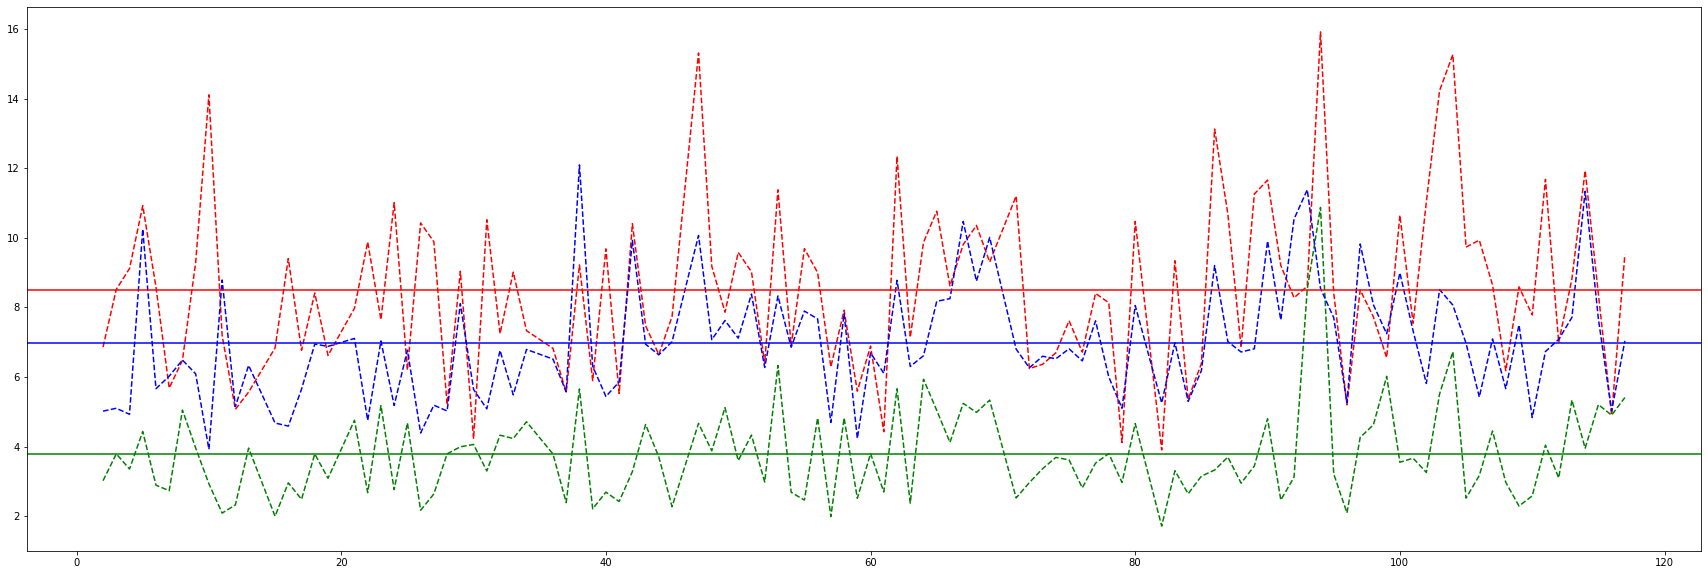

In [65]:
# plot a figure show each model error of each station and the mean error of each model
plt.figure(figsize=(30,10))
l1 = plt.plot(statistic_bais_20percent['number'],statistic_bais_20percent['NN_error'], 'r--')
l2 = plt.plot(statistic_bais_20percent['number'],statistic_bais_20percent['RF_error'], 'g--')
l3 = plt.plot(statistic_bais_20percent['number'],statistic_bais_20percent['LR_error'], 'b--')
NN_model_mean_error = statistic_bais_20percent['NN_error'].mean()
RF_model_mean_error = statistic_bais_20percent['RF_error'].mean()
LR_model_mean_error = statistic_bais_20percent['LR_error'].mean()
plt.axhline(y=NN_model_mean_error,color="red")
plt.axhline(y=RF_model_mean_error,color="green")
plt.axhline(y=LR_model_mean_error,color="blue")

### We do the regression for the whole dataset, and compare three regression method Netural Network, Random Forest and Linear Regression
Here we can see that Random Forest is the best model to fit this dataset as a whole with a small bais which is the abs of prediction value minus test value.

# Single Station

In [66]:
def calculate_mse(station_weather_normal,station_weather):
    '''sample the normalization train and test set'''
#     we delete 'bike_stands' feature due to normalization result to a Nan value, which will cause some error.
    X = station_weather_normal.loc[:,('weekday', 'hour', 'temp', 'pressure', 'wind_speed','humidity')]
    y = station_weather_normal.loc[:,('available_bike_stands')]
    # train and test set division
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    '''calculate the Netrual Network MSE'''
    NN_model = MLPRegressor(solver = "lbfgs", max_iter = 10000, hidden_layer_sizes=(100,50), random_state=100)
    NN_model.fit(X_train, y_train)
    NN_prediction = NN_model.predict(X_test)
    # NN_prediction = np.around(NN_prediction)
    initial = station_weather.loc[:,('available_bike_stands')]
    y_real = y_test * (initial.max()-initial.min()) + initial.mean()
    NN_prediction_real = NN_prediction * (initial.max()-initial.min()) + initial.mean()
    mse_NN = mean_squared_error(NN_prediction_real, y_real)
    NN_MSE.append(mse_NN)
    
    '''sample the train and test set'''
    X = station_weather.loc[:,('bike_stands', 'weekday', 'hour', 'temp', 'pressure', 'wind_speed','humidity')]
    y = station_weather.loc[:,('available_bike_stands')]
    # train and test set division
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    '''calculate the Random Forest MSE'''
    RF_model = RandomForestRegressor(n_estimators=100, random_state=1)
    RF_model.fit(X_train, y_train)
    RF_prediction = RF_model.predict(X_test)
    RF_prediction = np.around(RF_prediction)
    mse_RF = mean_squared_error(RF_prediction, y_test)
    RF_MSE.append(mse_RF)
    
    '''calculate the Linear Regression MSE'''
    LR_model = LinearRegression()
    LR_model.fit(X_train,y_train)
    LR_prediction = LR_model.predict(X_test)
    # RF_prediction = np.around(RF_prediction)
    mse_LR = mean_squared_error(LR_prediction, y_test)
    LR_MSE.append(mse_LR)

In [106]:
# drop the duplicate data
dynamic_station_each = dynamic_station.drop_duplicates()
dynamic_station_each = dynamic_station_each.dropna()
dynamic_weather_each = dynamic_weather.drop_duplicates()
dynamic_weather_each = dynamic_weather_each.dropna()
# convert the timestamp to date week and hours
dynamic_station_each["last_update"] = pd.to_datetime(dynamic_station_each["last_update"], unit = "ms")
dynamic_weather_each["last_update"] = pd.to_datetime(dynamic_weather_each["dt"], unit = "s")
# add weekday to table as a column
dynamic_station_each["weekday"] = dynamic_station_each["last_update"].map(lambda x: x.weekday())
dynamic_weather_each["weekday"] = dynamic_weather_each["last_update"].map(lambda x: x.weekday())
# add hour to table as a column
dynamic_station_each["hour"] = pd.to_datetime(dynamic_station_each["last_update"], format='%Y-%M-%D %H:%M:%S').dt.hour
dynamic_weather_each["hour"] = pd.to_datetime(dynamic_weather_each["last_update"], format='%Y-%M-%D %H:%M:%S').dt.hour
# merge two dynamic dataframe according to the nearest date
dynamic_station_each = dynamic_station_each.sort_values(['last_update'])
dynamic_weather_each = dynamic_weather_each.sort_values(['last_update'])
dynamic_weather_each = dynamic_weather_each.drop(columns=["weekday","hour","dt"])
station_weather_each = pd.merge_asof(dynamic_station_each, dynamic_weather_each,
                               on = "last_update",by = "number", 
                                direction="nearest", tolerance = pd.Timedelta("2 hour"))
static_station_each = static_station.drop(columns=["name","lat","lng"])
station_weather_each = pd.merge(station_weather_each,static_station_each)
station_weather_each = station_weather_each.dropna()

In [109]:
number_array = station_weather_each['number'].unique()

In [69]:
# normalization for nn model
def each_normal(station_weather_each):
#     for each station they have the same bike stand which normalization will get an Nan value
#     here we can only delete this feature
    station_weather_each_normal = station_weather_each.loc[:,('available_bike_stands', 'weekday', 'hour', 'temp', 'pressure', 'wind_speed','humidity')]
    station_weather_each_normal = (station_weather_each_normal - station_weather_each_normal.mean()) / (station_weather_each_normal.max() - station_weather_each_normal.min())
    station_weather_each_normal = station_weather_each_normal.dropna()
    return station_weather_each_normal

In [70]:
NN_MSE = []
RF_MSE = []
LR_MSE = []
for number in number_array:
    calculate_mse(each_normal(station_weather_each[station_weather_each['number']==number]),station_weather_each[station_weather_each['number']==number])

In [ ]:
each_station_model_compare = {"number":number_array, "NN_MSE":NN_MSE, "RF_MSE":RF_MSE, "LR_MSE":LR_MSE}
each_station_model_compare = pd.DataFrame(each_station_model_compare)
each_station_model_compare = each_station_model_compare.sort_values(by = ['number'])
each_station_model_compare

In [71]:
each_station_model_compare = {"number":number_array, "NN_MSE":NN_MSE, "RF_MSE":RF_MSE, "LR_MSE":LR_MSE}
each_station_model_compare = pd.DataFrame(each_station_model_compare)
each_station_model_compare = each_station_model_compare.sort_values(by = ['number'])
each_station_model_compare

,number,NN_MSE,RF_MSE,LR_MSE
10,2,11.910719,9.948617,22.440197
15,3,6.977754,6.662252,32.231123
53,4,8.939652,8.501961,26.679313
40,5,36.408872,34.595745,117.378328
79,6,8.317115,7.689394,30.157511
...,...,...,...,...
66,113,15.039514,12.794258,64.798936
39,114,38.452300,37.787798,125.715849
57,115,10.146773,9.595930,37.969142
69,116,13.606401,13.624309,36.185856


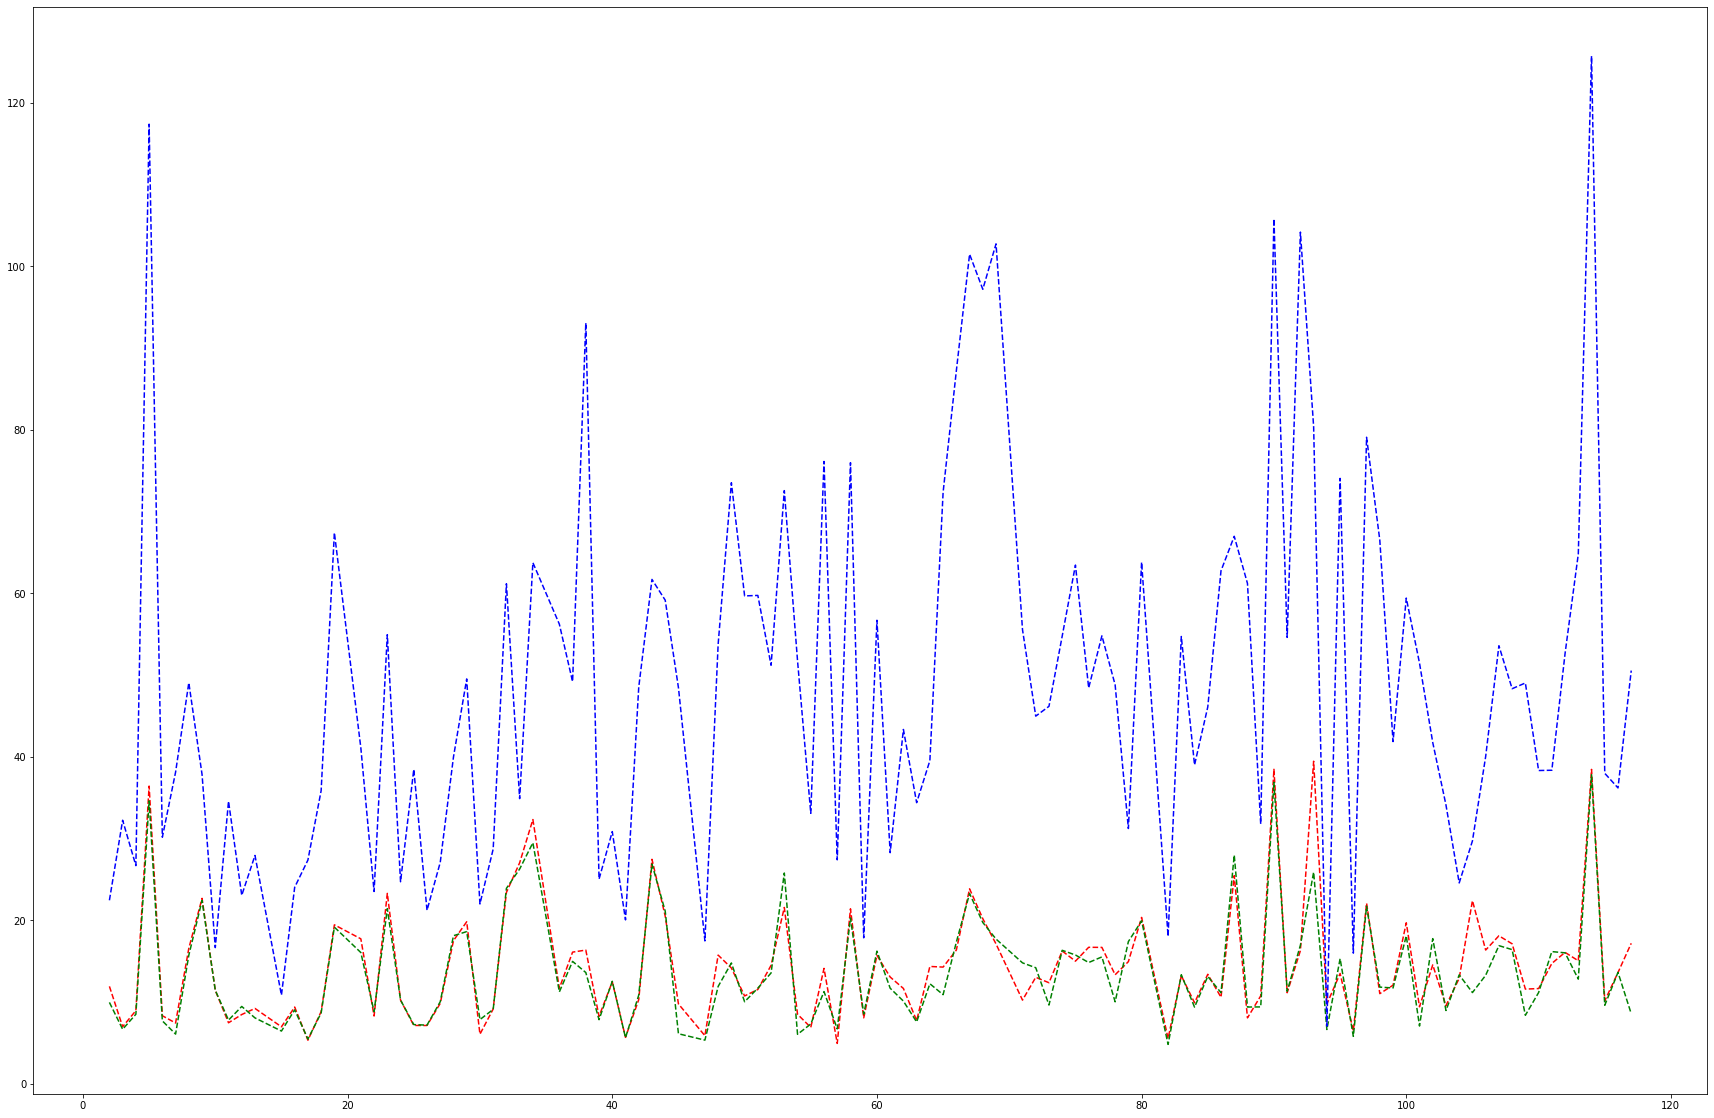

In [72]:
plt.figure(figsize=(30,20))
l1 = plt.plot(each_station_model_compare['number'],each_station_model_compare['NN_MSE'], 'r--')
l2 = plt.plot(each_station_model_compare['number'],each_station_model_compare['RF_MSE'], 'g--')
l3 = plt.plot(each_station_model_compare['number'],each_station_model_compare['LR_MSE'], 'b--')

As shown above, it's not difficult to find that Random Forest have a better result as we compare their error according to the whole dataset. The Netural Network seems also have a good performance in single stations model. However, NN need to normalization and it takes longer time to regression actrually. So we decide to Use the Random Forest as our model to do the next step to improve.

# Classifier hour feature to improve the model
Normally, Ireland's work time is from 9am to 5pm which is 9 to 17 in this case. We define them as hour_level1.  
And we also take the beforehead 2 hours and afterwards 2 hours as commute time it can be the time that bike uses more frequently which is hour_level2.  
During weekend day times, most people have a break, they have more preference to cycle outside. So we regard the day time on weekend from 7 to 19 as hour_level3.  
The sleep time from 19 to next day 7 as hour_level4.

In [73]:
hourcls_feature_station_weather_each = station_weather_each

In [74]:
def hour_level1(x): 
    '''workday time'''
    if x['weekday'] in range(5) and x['hour'] in range(9,18):
        return 1
    else:
        return 0
def hour_level2(x):
    '''commute time'''
    if x['weekday'] in range(5) and x['hour'] in range(7,9) and range(18,20):
        return 1
    else:
        return 0
def hour_level3(x):
    '''weekend cycle'''
    if x['weekday'] in range(5,7) and x['hour'] in range(7,20):
        return 1
    else:
        return 0
def hour_level4(x):
    '''sleep time'''
    if x['hour'] < 7 and x['hour'] > 20:
        return 1
    else:
        return 0
    
hourcls_feature_station_weather_each['hour_level1'] = hourcls_feature_station_weather_each.apply(hour_level1,axis = 1)
hourcls_feature_station_weather_each['hour_level2'] = hourcls_feature_station_weather_each.apply(hour_level2,axis = 1)
hourcls_feature_station_weather_each['hour_level3'] = hourcls_feature_station_weather_each.apply(hour_level3,axis = 1)
hourcls_feature_station_weather_each['hour_level4'] = hourcls_feature_station_weather_each.apply(hour_level4,axis = 1)

In [77]:
def RF_mse_hour(dataset):
    X = dataset.loc[:,('weekday', 'bike_stands', 'lat', 'lng', 'temp', 'pressure', 'wind_speed', 'humidity',
                      'hour_level1', 'hour_level2', 'hour_level3', 'hour_level4')]
    y = dataset.loc[:,('available_bike_stands')]
    # train and test set division
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    RF_model = RandomForestRegressor(n_estimators=100, random_state=1)
    RF_model.fit(X_train, y_train)
    RF_prediction = RF_model.predict(X_test)
#     RF_prediction = np.around(RF_prediction)
    mse_RF = mean_squared_error(RF_prediction, y_test)
    new_RF_MSE.append(mse_RF)

In [78]:
# calculate each station mse
new_RF_MSE = []
for number in number_array:
    RF_mse_hour(hourcls_feature_station_weather_each[hourcls_feature_station_weather_each['number']==number])
#     calculate_mse(station_weather_each[station_weather_each['number']==number])

In [79]:
# calculate each station mean error
each_station_hour_error_mean = []
for number in number_array:
#     shuffle number 
# choose proper model in each station
    X = hourcls_feature_station_weather_each[hourcls_feature_station_weather_each['number']==number].loc[:,
                    ('weekday', 'bike_stands', 'lat', 'lng', 'temp', 'pressure', 'wind_speed','humidity',
                      'hour_level1', 'hour_level2', 'hour_level3', 'hour_level4')]
    y = hourcls_feature_station_weather_each[hourcls_feature_station_weather_each['number']==number].loc[:,('available_bike_stands')]
    # train and test set division
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    RF_model = RandomForestRegressor()
    RF_model.fit(X_train, y_train)
    RF_prediction = RF_model.predict(X_test)
    RF_prediction = np.around(RF_prediction)
    locals()['hour_error_'+str(number)] = RF_prediction-y_test
    each_station_hour_error_mean.append(abs(locals()['hour_error_'+str(number)]).mean())

In [81]:
each_station_model_hourcls = {"number":number_array, "RF_MSE":new_RF_MSE, "RF_error":each_station_hour_error_mean}
each_station_model_hourcls = pd.DataFrame(each_station_model_hourcls)
each_station_model_hourcls = each_station_model_hourcls.sort_values(by = ['number'])
each_station_model_hourcls

,number,RF_MSE,RF_error
10,2,9.509945,2.454545
15,3,6.589267,2.096026
53,4,8.985874,2.168627
40,5,35.706987,4.534279
79,6,7.509783,2.193182
...,...,...,...
66,113,11.269627,2.172249
39,114,37.838918,4.535809
57,115,9.612546,2.636628
69,116,13.814142,2.408840


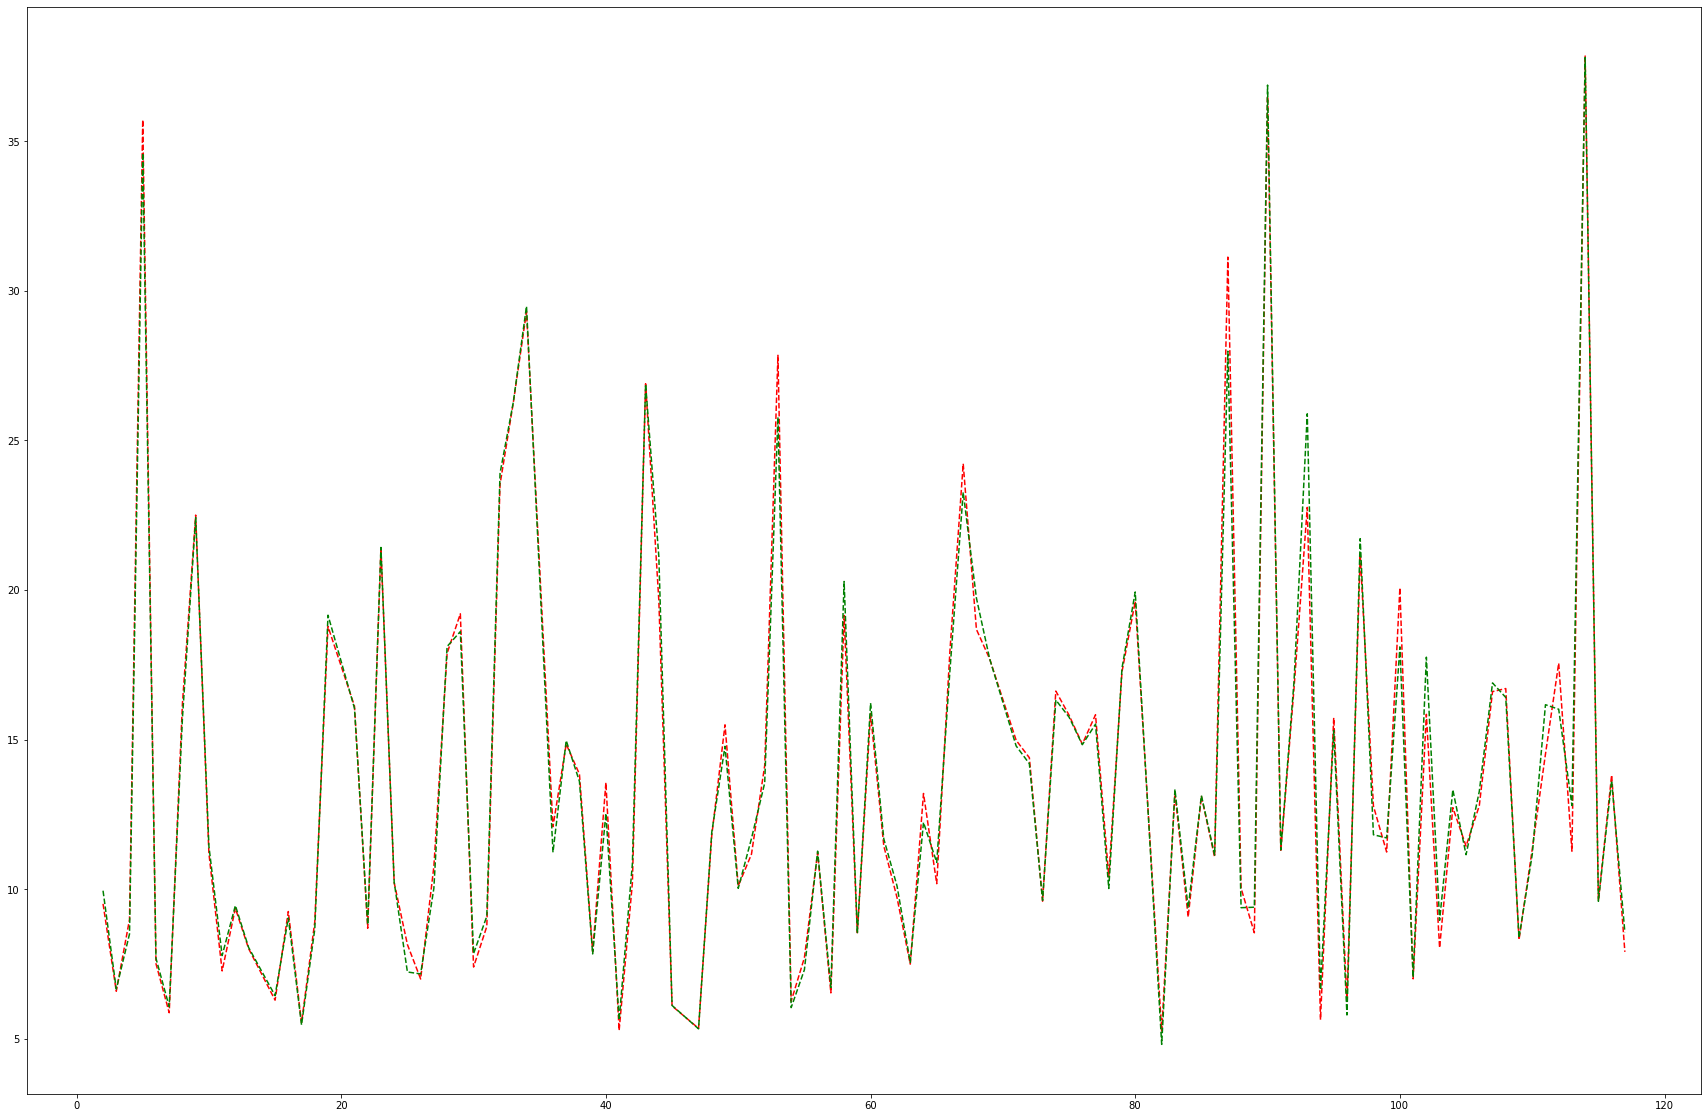

In [82]:
plt.figure(figsize=(30,20))
l1 = plt.plot(each_station_model_hourcls['number'],each_station_model_hourcls['RF_MSE'], 'r--')
l2 = plt.plot(each_station_model_compare['number'],each_station_model_compare['RF_MSE'], 'g--')

The green line shows the MSE after classification, and the red line shows the original MSE. Through comparison, we found that the site with lower MSE was optimized after classification, but the error of the original site with higher MSE was improved to a certain extent. The optimization of the model is not obvious

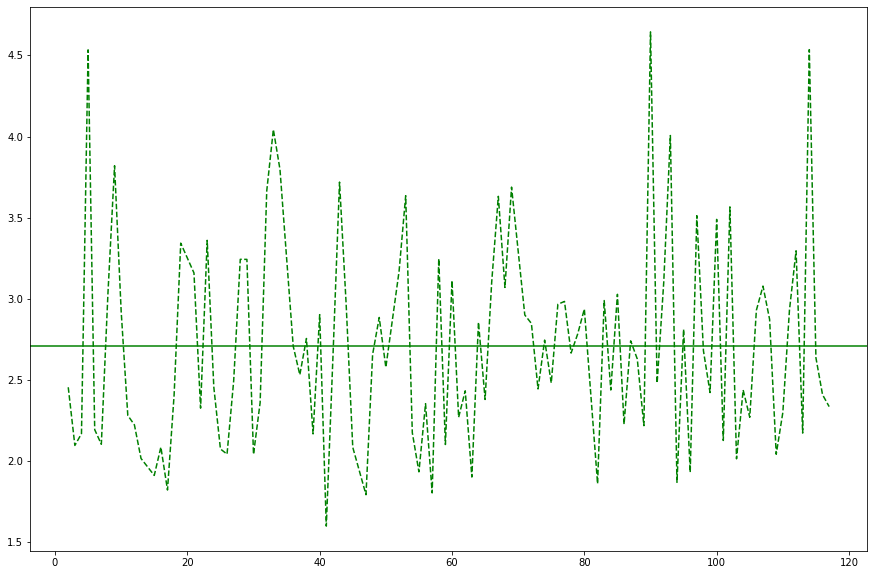

In [88]:
# plot the mean line
each_station_error_mean_hourcls = {"number":number_array, "error_mean":each_station_hour_error_mean}
each_station_error_mean_hourcls = pd.DataFrame(each_station_error_mean_hourcls)
each_station_error_mean_hourcls = each_station_error_mean_hourcls.sort_values(by=['number'])
hour_average_mean = each_station_error_mean_hourcls['error_mean'].mean()
plt.figure(figsize=(15,10))
plt.plot(each_station_error_mean_hourcls['number'],each_station_error_mean_hourcls['error_mean'],'--g')
plt.axhline(y=hour_average_mean,color="green")

# Splite the weekday feature to improve the feature

In [89]:
# assign the classifier dataframe to a new one for this process
weekday_hourcls_feature_station_weather_each = hourcls_feature_station_weather_each

In [90]:
week = ['monday', 'tuesday', 'wednesday', 'tursday', 'friday', 'saturday', 'sunday']
'''splite the weekdays'''
def monday(x):
    if x['weekday'] == 0:
        return 1
    else:
        return 0
def tuesday(x):
    if x['weekday'] == 1:
        return 1
    else:
        return 0
def wednesday(x):
    if x['weekday'] == 2:
        return 1
    else:
        return 0
def tursday(x):
    if x['weekday'] == 3:
        return 1
    else:
        return 0
def friday(x):
    if x['weekday'] == 4:
        return 1
    else:
        return 0
def saturday(x):
    if x['weekday'] == 5:
        return 1
    else:
        return 0
def sunday(x):
    if x['weekday'] == 6:
        return 1
    else:
        return 0
for day in week:
    weekday_hourcls_feature_station_weather_each[day] = weekday_hourcls_feature_station_weather_each.apply(eval(day),axis = 1)

In [91]:
def RF_mse_weekday_hour(dataset):
    X = dataset.loc[:,('bike_stands', 'lat', 'lng', 'temp', 'pressure', 'wind_speed','humidity',
                      'hour_level1', 'hour_level2', 'hour_level3', 'hour_level4', 
                       'monday', 'tuesday', 'wednesday', 'tursday', 'friday', 'saturday', 'sunday')]
    y = dataset.loc[:,('available_bike_stands')]
    # train and test set division
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    RF_model = RandomForestRegressor(n_estimators=100, random_state=1)
    RF_model = RF_model.fit(X_train, y_train)
    RF_prediction = RF_model.predict(X_test)
#     RF_prediction = np.around(RF_prediction)
    mse_RF = mean_squared_error(RF_prediction, y_test)
    accurancy = RF_model.score(X_test,y_test)
    weekday_hour_RF_acc.append(accurancy)
    weekday_hour_RF_MSE.append(mse_RF)

In [92]:
for number in number_array:
    X = weekday_hourcls_feature_station_weather_each[weekday_hourcls_feature_station_weather_each['number']==number].loc[:,
                    ('bike_stands', 'lat', 'lng', 'temp', 'pressure', 'wind_speed','humidity',
                      'hour_level1', 'hour_level2', 'hour_level3', 'hour_level4', 
                       'monday', 'tuesday', 'wednesday', 'tursday', 'friday', 'saturday', 'sunday')]
    y = weekday_hourcls_feature_station_weather_each[weekday_hourcls_feature_station_weather_each['number']==number].loc[:,('available_bike_stands')]
    # train and test set division
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    RF_model = RandomForestRegressor()
    RF_model.fit(X_train, y_train)
    RF_prediction = RF_model.predict(X_test)
    RF_prediction = np.around(RF_prediction)
    locals()['error_'+str(number)] = RF_prediction-y_test

In [95]:
weekday_hour_RF_MSE = []
weekday_hour_RF_acc = []
for number in number_array:
    RF_mse_weekday_hour(weekday_hourcls_feature_station_weather_each[weekday_hourcls_feature_station_weather_each['number']==number])

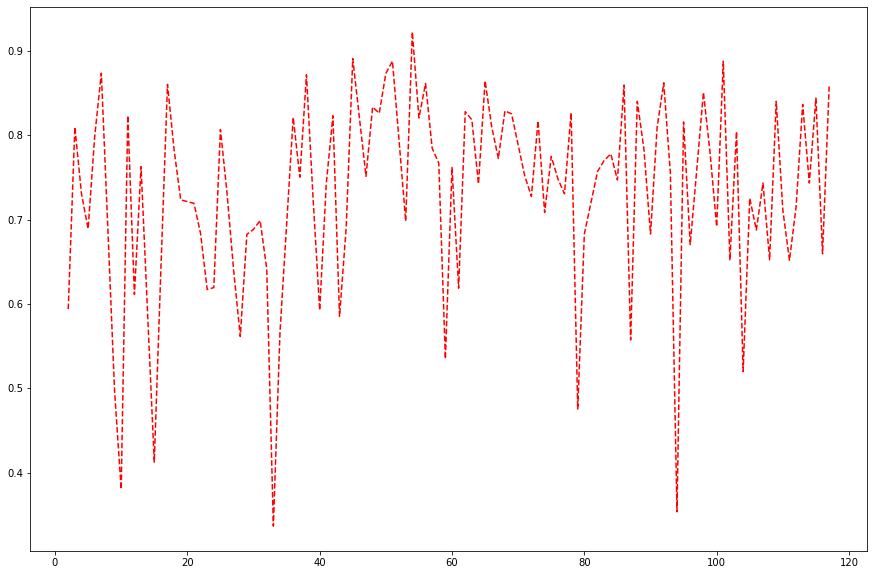

In [96]:
weekday_hour_acc = {'number':number_array, 'ACC':weekday_hour_RF_acc}
weekday_hour_acc = pd.DataFrame(weekday_hour_acc)
weekday_hour_acc = weekday_hour_acc.sort_values(by=['number'])
plt.figure(figsize=(15,10))
l1 = plt.plot(weekday_hour_acc['number'],weekday_hour_acc['ACC'], 'r--')

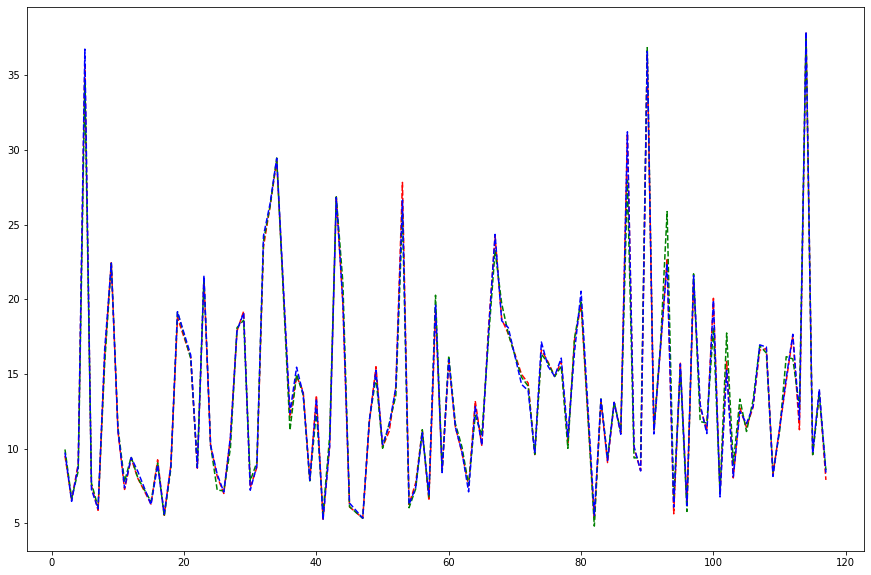

In [97]:
weekday_hour_mse = {'number':number_array, 'MSE':weekday_hour_RF_MSE}
weekday_hour_mse = pd.DataFrame(weekday_hour_mse)
weekday_hour_mse = weekday_hour_mse.sort_values(by=['number'])
plt.figure(figsize=(15,10))
l1 = plt.plot(each_station_model_hourcls['number'],each_station_model_hourcls['RF_MSE'], 'r--')
l2 = plt.plot(each_station_model_compare['number'],each_station_model_compare['RF_MSE'], 'g--')
l3 = plt.plot(weekday_hour_mse['number'],weekday_hour_mse['MSE'],'b--')

In [98]:
# calculate each station error mean
means = []
for number in number_array:
    means.append(abs(locals()['error_'+str(number)]).mean())

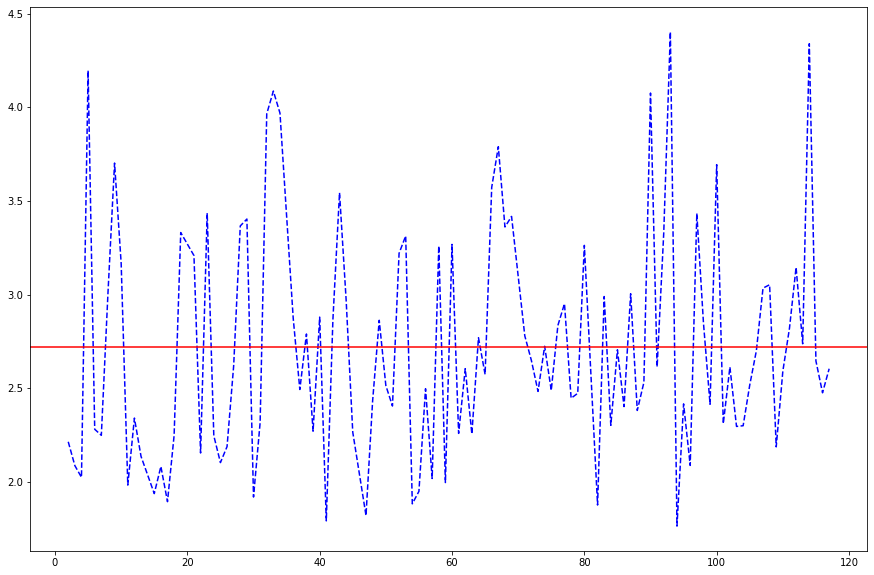

In [99]:
# plot the mean line
each_station_error_mean = {"number":number_array, "error_mean":means}
each_station_error_mean = pd.DataFrame(each_station_error_mean)
each_station_error_mean = each_station_error_mean.sort_values(by=['number'])
average_mean = each_station_error_mean['error_mean'].mean()
plt.figure(figsize=(15,10))
plt.plot(each_station_error_mean['number'],each_station_error_mean['error_mean'],'--b')
plt.axhline(y=average_mean,color="red")

In [100]:
average_mean,hour_average_mean

(2.7211887300415207, 2.711038923169965)

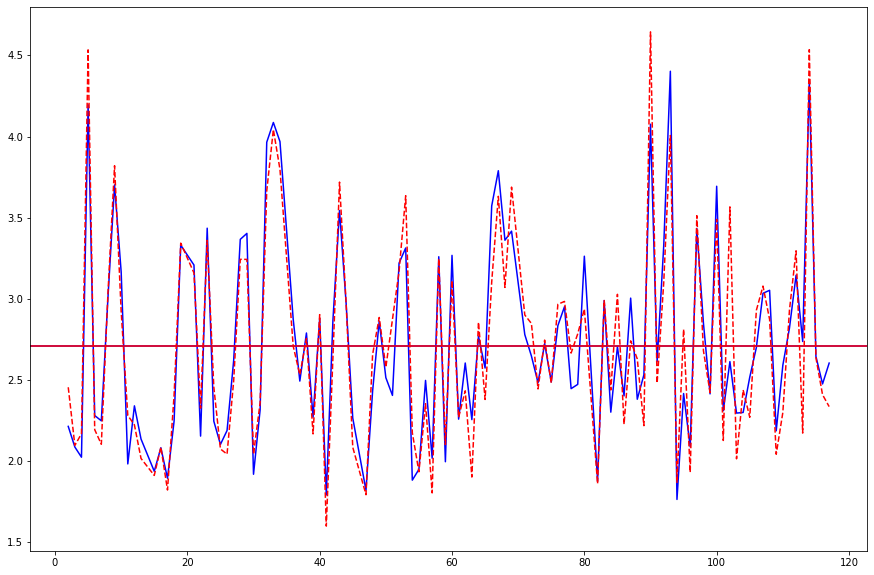

In [101]:
plt.figure(figsize=(15,10))
plt.plot(each_station_error_mean['number'],each_station_error_mean['error_mean'],'-b')
plt.axhline(y=hour_average_mean,color="blue")
plt.plot(each_station_error_mean_hourcls['number'],each_station_error_mean_hourcls['error_mean'],'--r')
plt.axhline(y=hour_average_mean,color="red")

### As we classifier the hour or weekdays. It seem that's not have an obvious improvement. The simple numerical mean is close to 2.7. It means that the prediction result can have near 2.7 error. It cannot be a problem if there are more than this number vacancy. So we decied to take the initial feature as X to set up the model. The feature list is ['bike_stands','weekday', 'hour', 'temp', 'pressure', 'wind_speed','humidity']. 

# Save each station model to a pickle file

In [111]:
def savepickle():
    for number in number_array:
        each_station_ds = station_weather_each[station_weather_each['number']==number]
        X = each_station_ds.loc[:,('bike_stands','weekday', 'hour', 'temp', 'pressure', 'wind_speed','humidity')]
        y = each_station_ds.loc[:,('available_bike_stands')]
        # train and test set division
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        RF_model = RandomForestRegressor(n_estimators=100, random_state=1)
        RF_model.fit(X_train, y_train)
        RF = RF_model.fit(X_train, y_train)
        # save the model to a pickle file
        filename = 'station_'+str(number)+'.sav'
        pickle.dump(RF, open(filename, 'wb'))

In [112]:
savepickle()

In [ ]:
def updatepickle():
    while True:
        savepickle()
#         sleep 1 hour here because we update the future weather data 1 hour
        time.sleep(60*60)

In [123]:
'''convert the dt to weekday and hour'''
future_weather = pd.read_sql_query("SELECT * FROM future_weather", dbikes)
future_weather["time"] = pd.to_datetime(future_weather["dt"], unit = "s")
# add weekday to table as a column
future_weather["weekday"] = future_weather["time"].map(lambda x: x.weekday())
# add hour to table as a column
future_weather["hour"] = pd.to_datetime(future_weather["time"], format='%Y-%M-%D %H:%M:%S').dt.hour

In [125]:
future_weather

,number,dt,lat,lng,weather,temp,pressure,wind_speed,humidity,pd_abs,time,weekday,hour
0,42,1649181600,53.3496,-6.27820,Rain,283.61,1002.0,7.86,89.0,0.0,2022-04-05 18:00:00,1,18
1,42,1649185200,53.3496,-6.27820,Clouds,283.72,1002.0,7.32,88.0,0.0,2022-04-05 19:00:00,1,19
2,42,1649188800,53.3496,-6.27820,Clouds,283.63,1002.0,7.76,87.0,0.0,2022-04-05 20:00:00,1,20
3,42,1649192400,53.3496,-6.27820,Clouds,283.50,1001.0,7.72,87.0,0.0,2022-04-05 21:00:00,1,21
4,42,1649196000,53.3496,-6.27820,Clouds,283.05,1001.0,7.98,85.0,0.0,2022-04-05 22:00:00,1,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5323,88,1649336400,53.3488,-6.28164,Clouds,281.49,992.0,7.40,58.0,0.0,2022-04-07 13:00:00,3,13
5324,88,1649340000,53.3488,-6.28164,Rain,281.33,993.0,6.71,55.0,0.0,2022-04-07 14:00:00,3,14
5325,88,1649343600,53.3488,-6.28164,Rain,281.94,994.0,7.34,54.0,0.0,2022-04-07 15:00:00,3,15
5326,88,1649347200,53.3488,-6.28164,Clouds,281.50,995.0,8.22,59.0,0.0,2022-04-07 16:00:00,3,16


In [ ]:
if not exists (select * from syscolumns where id=object_id('mytab') and name='columnname') alter table [mytab] add columnname nvarchar(max)


In [61]:
'''predict use the pickle file saved models'''
for number in number_array:
    RF = pickle.load(open('station_'+str(number)+'.sav', 'rb'))
    predect_xset = future_weather[future_weather['number']==number].loc[:,('weekday', 'hour', 'temp', 'pressure', 'wind_speed','humidity')]
    future_weather = pd.read_sql_query("'SELECT * FROM future_weather where number="+str(number)+"'", dbikes)
#     locals()['RF_predict_' + str(number)] = RF.predict(predect_xset)

In [126]:
RF_predict_4

array([14.3195058 , 13.32195238, 12.99114286, 12.8395    , 13.0635    ,
       13.08032143, 12.9812619 , 12.26860317, 11.16982143,  8.98236977,
        8.22073052,  7.06383297,  7.28410714,  8.76404654,  9.83856277,
       10.45762734, 11.49877814, 16.46908766, 15.32651587, 15.25015873,
       13.82510895, 11.1062114 , 13.45893434, 13.52919625, 13.88052958,
       13.03716667, 13.01054762, 15.45357143, 13.48267857, 12.32680808,
       11.97617147, 11.69074747,  8.64528499,  8.50512323,  8.49035895,
        7.8566324 ,  7.23015079,  6.98053283,  9.06969949,  7.23630592,
       10.20845743, 13.74278968, 14.34754762, 14.75994048, 14.88886508,
       14.8566746 , 14.6209246 , 14.55089683])

In [ ]:
weather_insert_query = "INSERT INTO dynamic_weather(number, lat, lng, dt, temp, pressure, wind_speed, humidity) VALUES(%s, %s, %s, %s, %s, %s, %s, %s)"
        weather_data = (int(station_row.get("number")),
                        float(weather["coord"].get("lat")),
                        float(weather["coord"].get("lon")),
                        int(weather["dt"]),
                        float(weather["main"].get("temp")),
                        float(weather["main"].get("pressure")),
                        float(weather["wind"].get("speed")),
                        float(weather["main"].get("humidity")))

#  Neural Network

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
X = station_weather.loc[:,('weekday', 'hour', 'lat', 'lng', 'temp', 'pressure', 'wind_speed','humidity')]
y = station_weather.loc[:,('available_bike_stands')]
# train and test set division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# NN for parameter regression
NN_model = MLPRegressor(solver = "lbfgs", max_iter = 2000, hidden_layer_sizes=(100,50), random_state=100)
NN_model.fit(X_train, y_train)
NN_prediction = NN_model.predict(X_test)
NN_prediction = np.around(NN_prediction)
mse_NN = mean_squared_error(NN_prediction, y_test)
print(mse_NN)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
X = station_weather_normal.loc[:,('weekday', 'hour', 'lat', 'lng', 'temp', 'pressure', 'wind_speed','humidity')]
y = station_weather_normal.loc[:,('available_bike_stands')]
# train and test set division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# NN for parameter regression
NN_model = MLPRegressor(solver = "adam", max_iter = 2000, hidden_layer_sizes=(100,50), random_state=100)
NN_model.fit(X_train, y_train)
NN_prediction = NN_model.predict(X_test)
# NN_prediction = np.around(NN_prediction)
mse_NN = mean_squared_error(NN_prediction, y_test)
print(mse_NN)

0.03200740516359079


## Sample 20000

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
X = station_weather_normal_sample.loc[:,('weekday', 'hour', 'lat', 'lng', 'temp', 'pressure', 'wind_speed','humidity')]
y = station_weather_normal_sample.loc[:,('available_bike_stands')]
# train and test set division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# NN for parameter regression
NN_model = MLPRegressor(solver = "adam", max_iter = 2000, hidden_layer_sizes=(100,50), random_state=100)
NN_model.fit(X_train, y_train)
NN_prediction = NN_model.predict(X_test)
# NN_prediction = np.around(NN_prediction)
mse_NN = mean_squared_error(NN_prediction, y_test)
print(mse_NN)

0.046475949114935626


In [ ]:
X_sample = X.sample()

## Normaliztion to real data

In [94]:
initial = station_weather.loc[:,('available_bike_stands')]
y_real = y_test * (initial.max()-initial.min()) + initial.mean()
NN_prediction_real = NN_prediction * (initial.max()-initial.min()) + initial.mean()
# station_weather_normal = (station_weather_normal - station_weather_normal.mean()) / (station_weather_normal.max() - station_weather_normal.min())

In [95]:
mse_NN = mean_squared_error(y_real, NN_prediction_real)
mse_NN

51.21184826174527

In [96]:
y.max()-y.min()

1.0

In [97]:
NN_prediction_real = np.around(NN_prediction_real)
NN_actual_predict = pd.DataFrame({"Predict": NN_prediction_real, "Actual": y_real})
NN_actual_predict

,Predict,Actual
2917,16.0,25.0
1327,32.0,37.0
519,22.0,23.0
4978,28.0,37.0
716,20.0,6.0
...,...,...
5150,24.0,12.0
2381,8.0,3.0
4283,7.0,10.0
4216,3.0,2.0


In [110]:
mse_NN = mean_squared_error(NN_prediction_real,y_real)
mse_NN

51.17948717948718

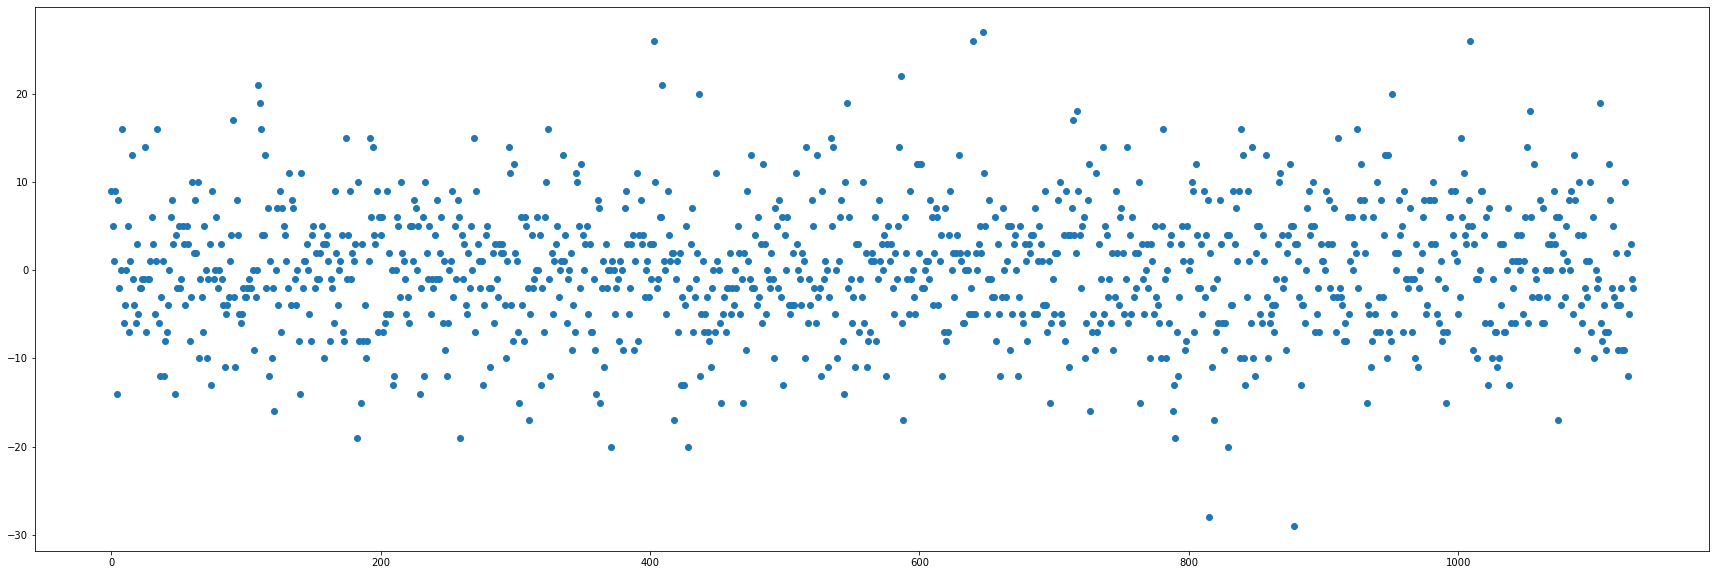

In [108]:
plt.figure(figsize=(30,10))
x = [i for i in range(len(NN_prediction_real))]
bais = y_real - NN_prediction_real
plt.scatter(x,bais)

In [31]:
X_train.describe()

,weekday,hour,lat,lng,temp,pressure,wind_speed,humidity
count,36837.000000,36837.000000,36837.000000,36837.000000,36837.000000,36837.000000,36837.000000,36837.000000
mean,-0.002867,-0.000168,-0.000950,-0.000550,0.000225,0.000534,-0.000365,0.000671
std,0.336571,0.255087,0.202007,0.202305,0.217923,0.215344,0.215793,0.247270
min,-0.422861,-0.550785,-0.503930,-0.559641,-0.645342,-0.616953,-0.427803,-0.487317
25%,-0.256195,-0.202959,-0.160766,-0.082938,-0.121723,-0.155414,-0.167707,-0.176972
50%,-0.089528,0.014432,0.024220,-0.000501,0.069630,-0.001568,-0.061615,-0.004558
75%,0.243805,0.231824,0.112692,0.138089,0.148893,0.126637,0.149199,0.202338
max,0.577139,0.449215,0.496070,0.440359,0.354658,0.383047,0.572197,0.512683


In [98]:
NN_prediction = np.around(NN_prediction)
NN_actual_predict = pd.DataFrame({"Predict": y_test, "Actual": NN_prediction})
NN_actual_predict.head()

,Predict,Actual
2917,0.122215,-0.0
1327,0.422215,0.0
519,0.072215,0.0
4978,0.422215,0.0
716,-0.352785,-0.0


# Random Forest 

In [85]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor(n_estimators=100, random_state=1)
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
RF_prediction = np.around(RF_prediction)
mse_RF = mean_squared_error(RF_prediction, y_test)
mse_RF

30.45446507515473

In [86]:
RF_actual_predict = pd.DataFrame({"Predict": y_test, "Actual": RF_prediction})
RF_actual_predict

,Predict,Actual
2917,25,9.0
1327,37,36.0
519,23,21.0
4978,37,30.0
716,6,14.0
...,...,...
5150,12,25.0
2381,3,2.0
4283,10,11.0
4216,2,6.0


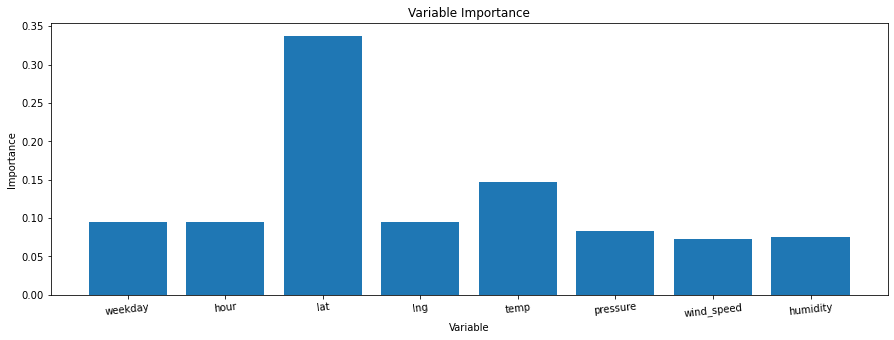

In [87]:
plt.figure(figsize=(15,5))
importance = list(RF_model.feature_importances_)
feature_list = list(X.columns)
x_values = list(range(len(importance)))
plt.bar(x_values, importance, orientation="vertical")
plt.xticks(x_values, feature_list,rotation = 6)
plt.ylabel("Importance")
plt.xlabel("Variable")
plt.title("Variable Importance")
plt.show()

In [36]:
X_train

,weekday,hour,lat,lng,temp,pressure,wind_speed,humidity
15843,-0.422861,0.188345,-0.099104,-0.293213,0.051215,0.152278,-0.202615,-0.039041
39057,0.410472,-0.029046,0.294998,-0.000501,0.215346,0.075355,0.184791,-0.280420
788,0.410472,-0.116002,0.048349,0.226500,0.164105,0.100996,-0.167707,-0.280420
40742,-0.422861,-0.159481,-0.318943,-0.026785,0.183321,-0.001568,-0.202615,0.271304
43334,0.410472,0.231824,0.201164,-0.025591,0.123273,0.024073,0.219699,-0.245938
...,...,...,...,...,...,...,...,...
21243,-0.422861,-0.507307,-0.187576,-0.442556,0.132880,-0.078491,0.219699,-0.039041
45891,0.243805,0.188345,0.061754,0.101052,0.208941,0.254842,-0.202615,-0.418351
42613,0.077139,-0.116002,0.093925,0.130921,-0.345102,-0.206696,0.149199,-0.073524
43567,0.077139,0.405737,-0.268005,0.001888,-0.289858,-0.001568,-0.132115,0.064407


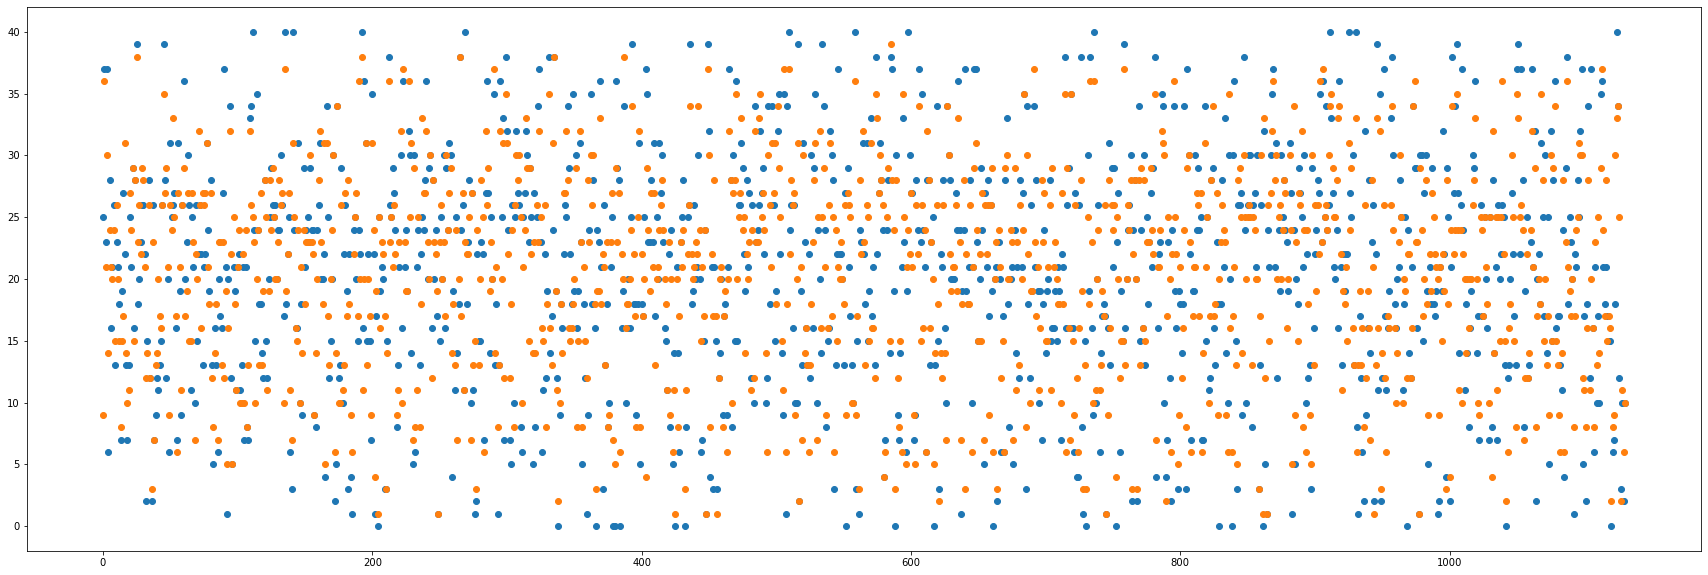

In [89]:
plt.figure(figsize=(30,10))
x = [i for i in range(len(y_test))]
bais = y_test - RF_prediction
plt.scatter(x,y_test)
plt.scatter(x,RF_prediction)

In [117]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor(n_estimators=100, random_state=1)
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_train)
RF_prediction = np.around(RF_prediction)
mse_RF = mean_squared_error(RF_prediction, y_train)
mse_RF

0.06160066295407693

In [116]:
plt.figure(figsize=(30,10))
x = [i for i in range(len(y_test))]
bais = y_test - RF_prediction
plt.scatter(x,y_test)
plt.scatter(x,RF_prediction)

ValueError: operands could not be broadcast together with shapes (1131,) (4524,) 

<Figure size 2160x720 with 0 Axes>

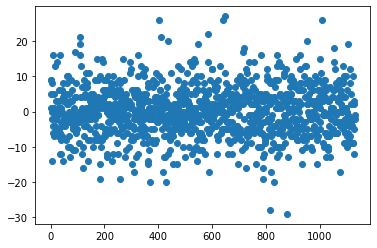

In [111]:
plt.scatter(x,bais)

The fit decreases as the sample size increases